In [ ]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np 
import shap 
from datetime import datetime
import plotly.express as px 

In [2]:
timedata = pd.read_csv('timedata.csv')

In [3]:
timedata.head()

,Year,Month,Day,Time (UTC),Temp (°C)
0,2021,1,1,00:00,1.2
1,2021,1,1,01:00,1.0
2,2021,1,1,02:00,0.8
3,2021,1,1,03:00,-1.4
4,2021,1,1,04:00,-1.4


In [4]:
timedata.isnull().sum()   

Year          0
Month         0
Day           0
Time (UTC)    0
Temp (°C)     0
dtype: int64

In [10]:
timedata.dtypes

Year            int64
Month           int64
Day             int64
Time (UTC)    float64
Temp (°C)     float64
dtype: object

In [8]:
def time_to_float(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M')
    return time_obj.hour + time_obj.minute / 60.0

In [9]:
timedata["Time (UTC)"] = timedata["Time (UTC)"].apply(time_to_float)

In [11]:
X = timedata[["Year", "Month", "Day", "Time (UTC)"]]

In [12]:
y = timedata["Temp (°C)"]

In [13]:
timedata['date'] = pd.to_datetime(timedata[['Year', 'Month', 'Day']])
timedata['day_of_year'] = timedata['date'].dt.dayofyear

In [46]:
px.line(timedata, x='date', y='Temp (°C)', title='Temperature over Time').show()

In [60]:
px.line(timedata, x='day_of_year', y='Temp (°C)', color='Year', title='Temperature for Each Day of the Year Across All Years').show()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=80, shuffle=True)

In [17]:
y_train.count

<bound method Series.count of 29744    -3.6
8555      7.0
26259    11.1
20608    26.0
21738    25.8
         ... 
15154    21.9
8714     -1.6
35027     5.0
19366    24.4
17583    13.9
Name: Temp (°C), Length: 31557, dtype: float64>

In [18]:
y_test.count

<bound method Series.count of 12599    22.0
34687     1.8
9474      5.8
21850    13.5
10855     5.9
         ... 
25358    19.6
7947      2.2
8226     14.9
30753     2.3
21775    12.8
Name: Temp (°C), Length: 3507, dtype: float64>

In [75]:
#{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 50, 'learning_rate': 0.2, 'gamma': 0.2, 'eta': 0.3, 'colsample_bytree': 1.0}
xgr = xgb.XGBRegressor(objective="reg:squarederror", subsample= 1.0, n_estimators= 400, max_depth=50, learning_rate=0.05, eta= 0.2, colsample_bytree= 1.0, reg_alpha=0.5, reg_lambda=1.0, min_child_weight=1, gamma=0.6)

In [76]:
xgr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=0.6, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [77]:
pred = xgr.predict(x_test)

In [78]:
mae = np.abs(mean_absolute_error(y_test, pred))
print("MAE : % f " %(mae))

MAE :  0.816202 


In [79]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [159]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 20,
    'eta': 0.2,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 1.0,
    'min_child_weight': 1,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'gamma': 0.1
    
}

In [160]:
model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'test')], early_stopping_rounds=4, verbose_eval=10)

[0]	test-rmse:9.85602
[10]	test-rmse:6.27658
[20]	test-rmse:4.14648
[30]	test-rmse:2.86461
[40]	test-rmse:2.10264
[50]	test-rmse:1.65945
[60]	test-rmse:1.39622
[70]	test-rmse:1.24752
[80]	test-rmse:1.15859
[90]	test-rmse:1.10294
[100]	test-rmse:1.06850
[110]	test-rmse:1.04384
[120]	test-rmse:1.02910
[130]	test-rmse:1.01795
[140]	test-rmse:1.01043
[150]	test-rmse:1.00481
[160]	test-rmse:0.99972
[170]	test-rmse:0.99927
[180]	test-rmse:0.99898
[190]	test-rmse:0.99852
[198]	test-rmse:0.99852


In [161]:
def evaluatemodel(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return ("MSE:", mse, "MAE:", mae, "R2:", r2)

In [162]:
evaluatemodel(model, dtrain, y_train)

('MSE:',
 0.10235721241025433,
 'MAE:',
 0.2408790516632045,
 'R2:',
 0.9990411706925187)

In [163]:
evaluatemodel(model, dtest, y_test)

('MSE:',
 0.9970454407443774,
 'MAE:',
 0.7149856535397927,
 'R2:',
 0.9906441707766956)

In [62]:
# can find best parameters for model using parameter search
param_dist = {
    'max_depth': [1, 3, 5, 10, 30, 50, 100, 200],
    'learning_rate': [0.05, 0.08, 0.1, 0.2],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200, 300, 400, 500],
    'objective': ['reg:squarederror'],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'min_child_weight': [1, 5, 10, 20],
    'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
    'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
}
randomsearch = RandomizedSearchCV(
    estimator=xgr,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    cv=10,
)

In [64]:
randomsearch.fit(x_train, y_train)
print("Best Params: ", randomsearch.best_params_)
print("Best score: % f " % np.abs(randomsearch.best_score_))

Best Params:  {'subsample': 1.0, 'reg_lambda': 0.3, 'reg_alpha': 0.2, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 200, 'learning_rate': 0.2, 'gamma': 0.5, 'eta': 0.4, 'colsample_bytree': 1.0}
Best score:  2.367427 


In [37]:
#shap value stuff below

In [38]:
xgb_explainer = shap.Explainer(model, x_train)
shap_values = xgb_explainer(x_test)

100%|===================| 3504/3507 [01:21<00:00]        

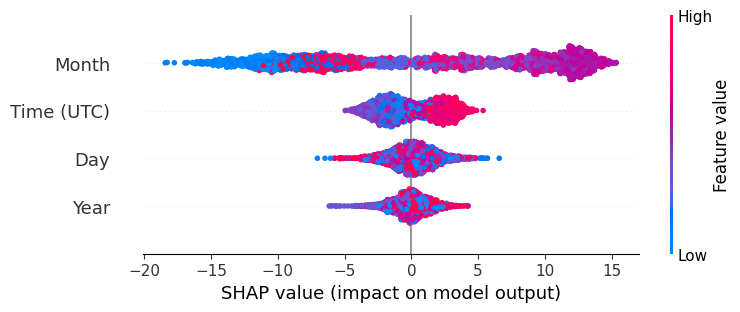

In [39]:
shap.plots.beeswarm(shap_values)

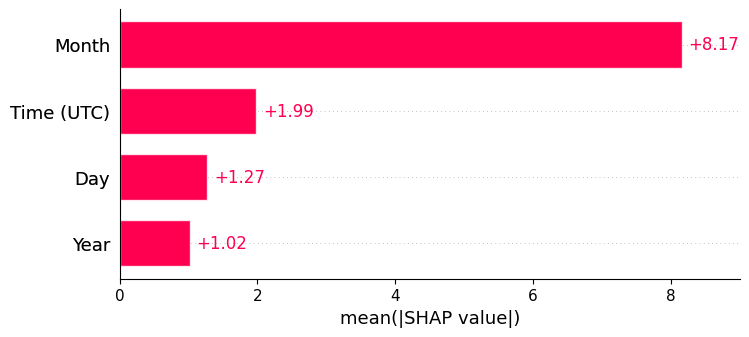

In [40]:
shap.plots.bar(shap_values)

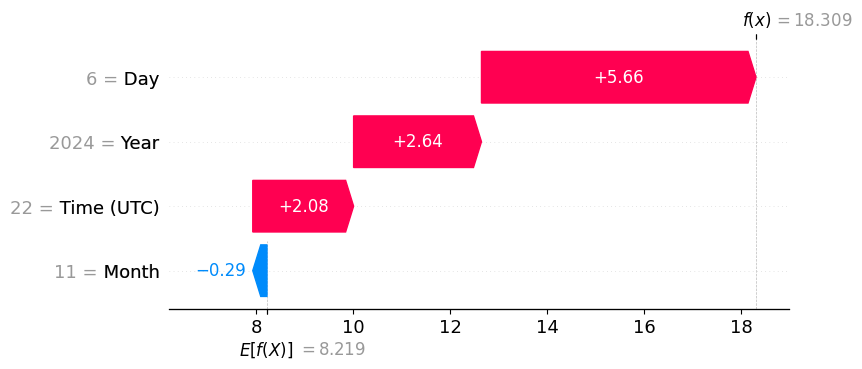

In [41]:
shap.plots.waterfall(shap_values[1200])

In [174]:
import pickle
shap_data = {
    'shap_values': shap_values.values,
    'base_values': shap_values.base_values,
    'data': shap_values.data,
    'feature_names': x_test.columns.tolist(),
}

In [175]:
with open('shap_data.pkl', 'wb') as f:
    pickle.dump(shap_data, f)

In [164]:
def predict_future_temp_time(year, month, day, time):
    future_date = pd.DataFrame({"Year": [year], "Month": [month], "Day": [day], "Time (UTC)": [time]})
    future_temp = model.predict(xgb.DMatrix(future_date))
    return future_temp[0]

In [172]:
predict_future_temp_time(2025, 4, 19, 17)

9.449891

In [ ]:
model.save_model("xgboost_regressor_time_modelv2.json") # can create a v3 model rn but maybe add more data then make a v3 